In [28]:
import torch
from torch import Tensor
from einops import rearrange, repeat
import torch.nn as nn

def rope(pos: Tensor, dim: int, theta: int) -> Tensor:
    assert dim % 2 == 0
    scale = torch.arange(0, dim, 2, dtype=torch.float64, device=pos.device) / dim # dim//2 개 만큼 0~1 interpoloate
    omega = 1.0 / (theta**scale) # 1 ~ 0 list
    out = torch.einsum("...n,d->...nd", pos, omega) # 각 position에 대해 omega 대입
    out = torch.stack([torch.cos(out), -torch.sin(out), torch.sin(out), torch.cos(out)], dim=-1)
    out = rearrange(out, "b n d (i j) -> b n d i j", i=2, j=2)
    return out.float()

In [29]:
class EmbedND(nn.Module):
    def __init__(self, dim: int, theta: int, axes_dim: list[int]):
        super().__init__()
        self.dim = dim
        self.theta = theta
        self.axes_dim = axes_dim

    def forward(self, ids: Tensor, theta: int = None) -> Tensor:
        n_axes = ids.shape[-1]
        emb = torch.cat(
            [rope(ids[..., i], self.axes_dim[i], theta if theta is not None else self.theta) for i in range(n_axes)],
            dim=-3,
        )

        return emb.unsqueeze(1)

In [30]:
theta = 50
#axes_dim = [16, 56, 56] # 128 dim
axes_dim = [64, 64]
hidden_size = 3072
num_heads=24

pe_dim = hidden_size // num_heads # 64
pe_embedder = EmbedND(dim=pe_dim, theta=theta, axes_dim=axes_dim)

In [31]:
batch = 1

#txt_ids = torch.zeros(batch, 256, 2)
img_ids = torch.zeros(axes_dim[0]//2, axes_dim[1]//2, 2)
img_ids[..., 0] = img_ids[..., 0] + torch.arange(32)[:, None]
img_ids[..., 1] = img_ids[..., 1] + torch.arange(32)[None : ]
img_ids = repeat(img_ids, "h w c -> b (h w) c", b=batch)

# ids = torch.cat((txt_ids, img_ids), dim=1)
ids = img_ids
print(ids.shape)
pe = pe_embedder(ids).squeeze(0).squeeze(0)
print(pe.shape)

torch.Size([1, 1024, 2])
torch.Size([1024, 64, 2, 2])


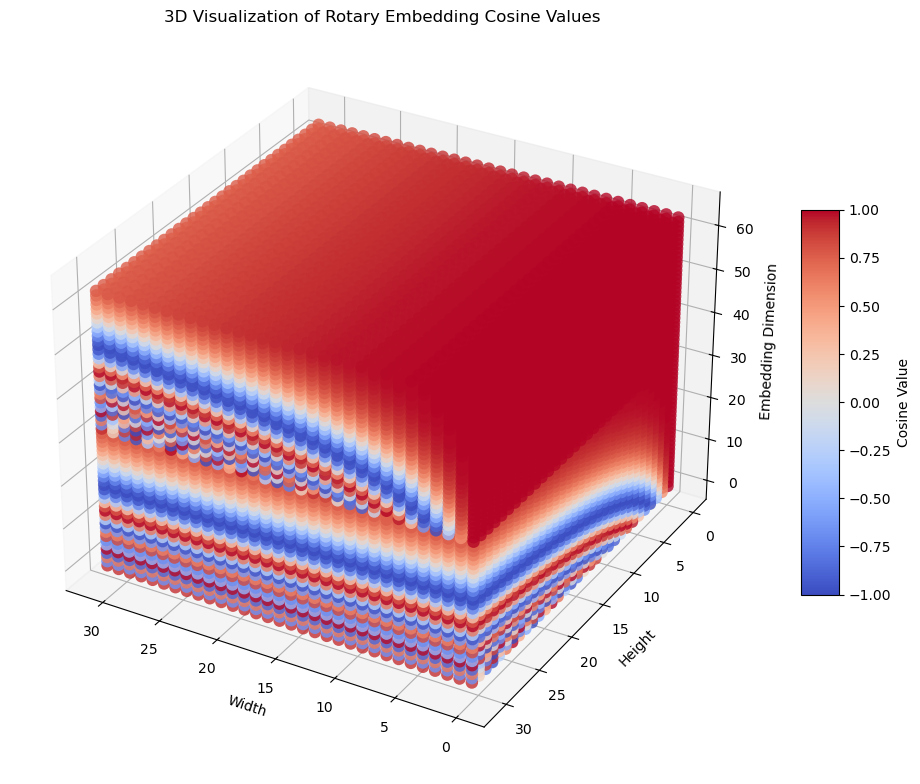

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


# 코사인 값 추출 (2x2 행렬에서 [0, 0]에 해당)
cos_values = pe[..., 0, 0]  # Shape: (1024, 64)

# 가로, 세로로 2D 재구성
height, width, dim = 32, 32, 64
cos_values = cos_values.reshape(height, width, dim).numpy()

# Grid 생성
x = np.arange(width)
y = np.arange(height)
X, Y = np.meshgrid(x, y)

# Normalize colors
norm = Normalize(vmin=-1, vmax=1)

# 3D 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each embedding dimension
for z in range(dim):
    # 각 임베딩 번호 z에 대해 (x, y) 위치에서의 cos 값
    Z = np.full_like(X, z)  # Z축은 임베딩 번호
    colors = plt.cm.coolwarm(norm(cos_values[:, :, z]))  # Z의 색상 결정

    # Scatter plot for each point
    ax.scatter(
        X, Y, Z, c=colors.reshape(-1, 4), s=80, alpha=0.8, edgecolor="none"
    )

# Axis labels and title
ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_zlabel("Embedding Dimension")
ax.set_title("3D Visualization of Rotary Embedding Cosine Values")
ax.view_init(30, 120)  # Adjust for better viewing angle

# Add colorbar
mappable = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label="Cosine Value")

plt.show()
